# Tutorial: BabI6 Training and Preprocessing in Python (Part II)

In Part I of this tutorial, we learned how to create {term}`DisCoCirc` circuits for question asking for the babI6 dataset. In this part, we proceed to train the model with the circuits that we created.

In [1]:
# Parameters determining the type of the data
# SANDWICH functor flag
SANDWICH = True

# Updating the FFL Parameter
FFL = False

# Names of Resulting file paths for the Datasets
TRAINING_DATASET_FILEPATH = 'tutorial_training_ffl' + str(FFL) + '_sandwich_' + str(SANDWICH) + '.pkl'
VALIDATION_DATASET_FILEPATH = 'tutorial_validation_ffl' + str(FFL) + '_sandwich_' + str(SANDWICH) + '.pkl'
TEST_DATASET_FILEPATH = 'tutorial_test_ffl' + str(FFL) + '_sandwich_' + str(SANDWICH) + '.pkl'

BATCH_SIZE = 5
EPOCHS = 30
LEARNING_RATE = 0.005

To guarantee reproducibility, we make sure to manually seed torch and random.

In [2]:
import torch
import numpy as np
import random

def set_pytorch_seed(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.use_deterministic_algorithms(True)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic =  True
    torch.backends.cudnn.benchmark = False

SEED = 2
set_pytorch_seed(SEED)
device = torch.device("cpu")

## 8. Training the Circuits and Tests
Now that we have the data ready, we proceed with the training as usual. However, we need to override the forward() method to deal with pairs of circuits instead of single circuits.

In [3]:
import pickle

training_dict_babi6 = {}
with open(TRAINING_DATASET_FILEPATH, 'rb') as file:
    training_dict_babi6 = pickle.load(file)

val_dict_babi6 = {}
with open(VALIDATION_DATASET_FILEPATH, 'rb') as file:
    val_dict_babi6 = pickle.load(file)

test_dict_babi6 = {}
with open(TEST_DATASET_FILEPATH, 'rb') as file:
    test_dict_babi6 = pickle.load(file)

/Users/ouissal.moumou/actual_discocirc/lambeq-docs/tutorials_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
training_circuits = []
training_answers = []
training_questions = []
training_contexts = []

for key, value in training_dict_babi6.items():
    training_answers.append(value['answer'])
    training_questions.append(value['question'])
    training_contexts.append(value['text'])
    training_circuits.append(value['quantum_circ_pair_aff_neg'])

val_circuits = []
val_answers = []
val_questions = []
val_contexts = []

for key, value in val_dict_babi6.items():
    val_answers.append(value['answer'])
    val_questions.append(value['question'])
    val_contexts.append(value['text'])
    val_circuits.append(value['quantum_circ_pair_aff_neg'])
    
test_circuits = []
test_answers = []
test_questions = []
test_contexts = []

for key, value in test_dict_babi6.items():
    test_answers.append(value['answer'])
    test_questions.append(value['question'])
    test_contexts.append(value['text'])
    test_circuits.append(value['quantum_circ_pair_aff_neg'])

The final output of the model is going to be a vector that we can interpret as a probability distribution over the possible answers (in this case [yes, no]). Therefore, We modify the yes and no answers and replace their representations with a one hot encoding over the possible assertions, i.e. by "[1, 0]"s and "[0, 1]"s respectively.

In [5]:
training_answers = [[0., 1.] if not answer else [1., 0.] for answer in training_answers]
val_answers = [[0., 1.] if not answer else [1., 0.] for answer in val_answers]
test_answers = [[0., 1.] if not answer else [1., 0.] for answer in test_answers]

In [6]:
# this is strictly for debugging and should be removed once cleared
len(training_answers)

62

The following shows how we override the forward() method to accommodate having pairs of circuits.

In [7]:
from lambeq import PytorchQuantumModel
from lambeq.backend.quantum import Diagram
import torch


class PairCircuitModel(PytorchQuantumModel):
    def forward(self, circ_pairs: list[tuple[Diagram, Diagram]]) -> torch.Tensor:
        aff_circs, neg_circs = zip(*circ_pairs)
        aff_out = abs(self.get_diagram_output(aff_circs))
        neg_out = abs(self.get_diagram_output(neg_circs))

        # implement a function that would merge aff_out and neg_out into an nx2 tensor
        out_tensor = torch.stack((aff_out, neg_out), dim=1)
        out_tensor = torch.softmax(out_tensor, dim=1)
    
        return out_tensor

The way circuits are stored in our current example is as pairs. However, we need to pass all the circuits to the model for initialization. Therefore, we will create a new collection of circuits that includes all the circuits from the pairs of circuits that we originally have.

In [8]:
all_circuits = [
    circuit
    for circuit_tuple in training_circuits + val_circuits + test_circuits
    for circuit in circuit_tuple
]

backend_config = {'backend': 'default.qubit'}  
model = PairCircuitModel.from_diagrams(all_circuits)
model.initialise_weights()


In [9]:
# This is strictly to debug the reproducibility problem and is not part of the tutorial
model.weights

Parameter containing:
tensor([0.6147, 0.3810, 0.6371, 0.4745, 0.7136, 0.6190, 0.4425, 0.0958, 0.6142,
        0.0573, 0.5657, 0.5332, 0.3901, 0.9088, 0.5334, 0.7073, 0.7116, 0.2050,
        0.3078, 0.9809, 0.0103, 0.4660, 0.4604, 0.8547, 0.4525, 0.6317, 0.4760,
        0.2200, 0.2166, 0.2571, 0.0458, 0.1755, 0.6177, 0.8291, 0.5246, 0.2708,
        0.7197, 0.3081, 0.3892, 0.2259, 0.3430, 0.0367, 0.7133, 0.6944, 0.5993,
        0.7455, 0.7119, 0.5221, 0.5530, 0.5382, 0.7668, 0.8359, 0.8591, 0.7898,
        0.3781, 0.4777, 0.3984, 0.7909, 0.5555, 0.9628, 0.7536, 0.0727, 0.6463,
        0.9804, 0.9441, 0.4921, 0.6659, 0.0310, 0.3406, 0.7438, 0.0445, 0.9356,
        0.1712, 0.6581, 0.4811, 0.5881, 0.5484, 0.0326, 0.3926, 0.1839, 0.9251,
        0.4386, 0.0021, 0.6211, 0.7171, 0.2762, 0.4531, 0.7162, 0.1889, 0.2357,
        0.4518, 0.1489, 0.8073, 0.5409, 0.7992, 0.7677, 0.1147, 0.1884, 0.1580,
        0.3393, 0.3173, 0.4194, 0.0163, 0.7111, 0.7837, 0.6585, 0.8177, 0.8756,
        0.0064, 0.

Finally, we proceed with training as usual (see previous tutorials for more details on this part).

In [10]:
def acc(y_hat, y):
    return (torch.argmax(y_hat, dim=1) ==
            torch.argmax(y, dim=1)).sum().item()/len(y)

def loss(y_hat, y):
    return torch.nn.functional.binary_cross_entropy(
        y_hat, torch.tensor(y, dtype=y_hat.dtype)
    )
eval_metrics = {"acc": acc}

In [11]:
from lambeq import Dataset

train_dataset = Dataset(training_circuits,
                        training_answers,
                        batch_size=BATCH_SIZE, shuffle=False)

val_dataset = Dataset(val_circuits, val_answers, shuffle=False)

In [12]:
len(val_dataset)

26

In [ ]:
# Currently, we print more than we need to debug the reproducibility problem
from lambeq import PytorchTrainer

trainer = PytorchTrainer(
        model=model,
        loss_function=loss,
        optimizer=torch.optim.Adam,
        learning_rate=LEARNING_RATE,
        epochs=EPOCHS,
        evaluate_functions=eval_metrics,
        evaluate_on_train=True,
        use_tensorboard=False,
        verbose='text', 
        seed=SEED
    )

trainer.fit(train_dataset, val_dataset)

Now that the training has ended, the final part is to test and plot the graphs for the results of the training as shown below. 

Text(12.4, 0.75, 'early stopping')

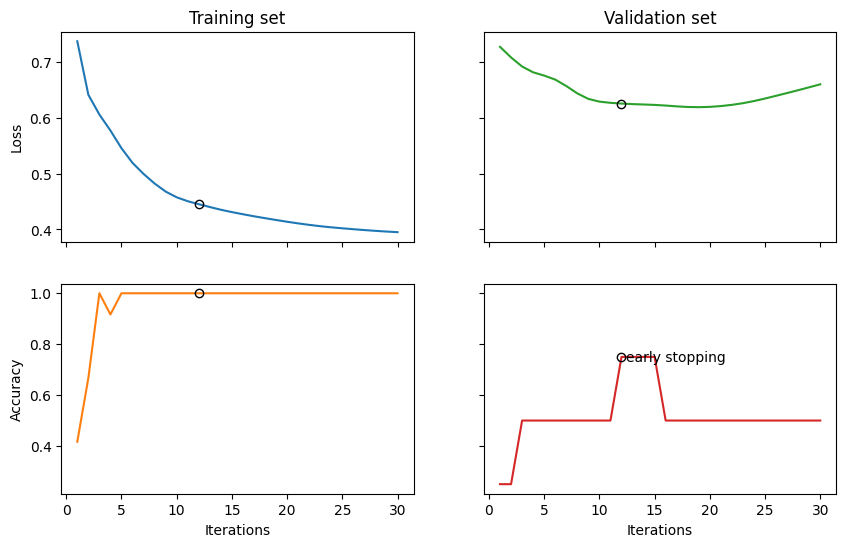

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Validation set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
range_ = np.arange(1, trainer.epochs + 1)
ax_tl.plot(range_, trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(range_, trainer.train_eval_results['acc'], color=next(colours))
ax_tr.plot(range_, trainer.val_costs, color=next(colours))
ax_br.plot(range_, trainer.val_eval_results['acc'], color=next(colours))

# mark best model as circle
best_epoch = np.argmax(trainer.val_eval_results['acc'])
ax_tl.plot(best_epoch + 1, trainer.train_epoch_costs[best_epoch], 'o', color='black', fillstyle='none')
ax_tr.plot(best_epoch + 1, trainer.val_costs[best_epoch], 'o', color='black', fillstyle='none')
ax_bl.plot(best_epoch + 1, trainer.train_eval_results['acc'][best_epoch], 'o', color='black', fillstyle='none')
ax_br.plot(best_epoch + 1, trainer.val_eval_results['acc'][best_epoch], 'o', color='black', fillstyle='none')

ax_br.text(best_epoch + 1.4, trainer.val_eval_results['acc'][best_epoch], 'early stopping', va='center')

Finally, We select the best model (from the best epoch) and use it to get the accuracy on the test data. The best epoch is determined based on the validation accuracy, which is marked on the plot by a circle.

In [ ]:
model.load(trainer.log_dir + '/best_model.lt')
test_acc = acc(model(test_circuits), torch.tensor(test_answers))
print('Test Accuracy:', test_acc)

Test Accuracy: 0.5
